In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


In [13]:
DATASET = 'fmnist'

In [14]:
if DATASET == 'fmnist':
    (nobkd_trn_x, nobkd_trn_y), (bkd_trn_x, bkd_trn_y), _, _ = np.load('/home/jnear/co/temp/auditing-dpsgd/datasets/fmnist/clipbkd-new-8.npy', allow_pickle=True)
elif DATASET == 'p100':
    (nobkd_trn_x, nobkd_trn_y), (bkd_trn_x, bkd_trn_y), _, _ = np.load('/home/jnear/co/temp/auditing-dpsgd/datasets/p100/p100_8.npy', allow_pickle=True)    

In [15]:
nobkd_trn_x = nobkd_trn_x.reshape(nobkd_trn_x.shape[0], -1)
bkd_trn_x = bkd_trn_x.reshape(bkd_trn_x.shape[0], -1)

In [29]:
nobkd_trn_x.shape

(6000, 784)

In [16]:
n_features = nobkd_trn_x.shape[1]
if DATASET == 'fmnist':
    n_classes = 2
elif DATASET == 'p100':
    n_classes = 100

In [17]:
BATCH_SIZE = 64

training_dataset_nobkd = TensorDataset(torch.from_numpy(nobkd_trn_x).float(), 
                                       torch.from_numpy(nobkd_trn_y).long())
train_loader_nobkd = DataLoader(training_dataset_nobkd, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

training_dataset_bkd = TensorDataset(torch.from_numpy(bkd_trn_x).float(), 
                                       torch.from_numpy(bkd_trn_y).long())
train_loader_bkd = DataLoader(training_dataset_bkd, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [18]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=256):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [19]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
#     print('outputs', outputs)
#     print('labels', labels)
    loss = criterion(torch.squeeze(outputs), labels)
#     print(loss)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]

    loss.backward()
    return loss, s

In [20]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    values, indices = outputs.max(dim=1)
    y_hat = indices.detach().numpy()
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

In [21]:
def run_experiment(train_loader, epsilon, epochs, add_noise=False, throw_out_threshold=False, logging=True):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.NLLLoss() 
    model_optimizer = optim.Adam(model.parameters())#,lr=0.001)
    alpha = 25
    epsilon_iter = epsilon / epochs

    info = defaultdict(lambda: [])
    train_accs = []
    test_accs = []
    advs = []
#     for p in model.parameters():
#         #torch.nn.init.xavier_uniform_(p.data, gain=0.5)
#         #print(p.data)
#         #torch.nn.init.uniform_(p.data, -0.01, 0.01)
#         p.data *= 0.0001
#         #print(p.data)

    
    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            plz_update = True

            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE

            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            if add_noise:
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad += (sigma * torch.randn(1).float())

            if plz_update:
                model_optimizer.step()

        lossfn = model_criterion
        
        if epoch % 10 == 0 and logging:
            acc = accuracy(model, nobkd_trn_x, nobkd_trn_y)
            print(f'Epoch {epoch}: acc {acc}')

    return info, model

In [22]:
info, model = run_experiment(train_loader_bkd, 10, 10, add_noise=True, throw_out_threshold=False)
accuracy(model, nobkd_trn_x, nobkd_trn_y)

Epoch 0: acc 0.976


0.9881666666666666

# Backdoor function

In [113]:
def backdoor(model, bkd_x, bkd_y):

    _, predsw  = model(torch.from_numpy(bkd_x).float()).max(dim=1)
    _, predswo = model(torch.from_numpy(np.zeros_like(bkd_x)).float()).max(dim=1)

    diff = (predsw - predswo).detach().numpy()
    pred = np.multiply(bkd_y, diff).sum()
    return pred

backdoor(model, bkd_trn_x, bkd_trn_y)

2890

In [114]:
np.sum(bkd_trn_y)

3040

In [181]:
def backdoor_experiment(train_loader, x, y, epsilon=1.0, epochs=10):
    info, model = run_experiment(train_loader, epsilon, epochs, add_noise=True, 
                                 throw_out_threshold=False, logging=False)
    
    n_backdoor = backdoor(model, x, y)
    return n_backdoor

In [170]:
print('nobkd experiments')
nobkd_results = [backdoor_experiment(train_loader_nobkd, nobkd_trn_x, nobkd_trn_y) for _ in range(100)]
print('bkd experiments')
bkd_results = [backdoor_experiment(train_loader_bkd, bkd_trn_x, bkd_trn_y) for _ in range(100)]


nobkd experiments
bkd experiments


In [182]:
from scipy import stats
def clopper_pearson(count, trials, conf):
    count, trials, conf = np.array(count), np.array(trials), np.array(conf)
    q = count / trials
    ci_low = stats.beta.ppf(conf / 2., count, trials - count + 1)
    ci_upp = stats.beta.isf(conf / 2., count + 1, trials - count)

    if np.ndim(ci_low) > 0:
        ci_low[q == 0] = 0
        ci_upp[q == 1] = 1
    else:
        ci_low = ci_low if (q != 0) else 0
        ci_upp = ci_upp if (q != 1) else 1
    return ci_low, ci_upp


In [238]:
def get_eps_thresh(nobkd_arr, bkd_arr, thresh):
    #thresh = 2800
    poisoning_size = 8
    
    bkd_ct = (bkd_arr >= thresh).sum()
    nobkd_ct = (nobkd_arr >= thresh).sum()
#     bkd_p = bkd_ct/bkd_arr.shape[0]
#     nobkd_p = nobkd_ct/nobkd_arr.shape[0]

    nobkd_lb, nobkd_ub = clopper_pearson(nobkd_ct, nobkd_arr.shape[0], .1)
    bkd_lb, bkd_ub = clopper_pearson(bkd_ct, bkd_arr.shape[0], .1)


    if nobkd_ub + bkd_lb > 1:
        corr_ratio = (1-nobkd_ub)/(1-bkd_lb)
    else:
        corr_ratio = bkd_lb/nobkd_ub

    corr_eps = np.log(corr_ratio)#/poisoning_size

#     print('threshold', thresh)
#     print('  upper and lower bounds, no backdoor:', nobkd_lb, nobkd_ub)
#     print('  upper and lower bounds, with backdoor:', bkd_lb, bkd_ub)
#     print('  ratio:', corr_ratio)
#     print('  epsilon:', corr_eps)

    #print(nobkd_lb, nobkd_ub, bkd_lb, bkd_ub, corr_ratio, corr_eps)
    return corr_eps

def get_eps(nobkd_arr, bkd_arr):
    all_arr = np.concatenate((nobkd_arr, bkd_arr)).ravel()
    all_threshs = np.unique(all_arr)
    all_threshs = all_threshs[all_threshs > 0]
    all_epsilons = [(thresh, get_eps_thresh(nobkd_arr, bkd_arr, thresh)) for thresh in all_threshs]
#     print(all_epsilons)
    thresh, corr_eps = max(all_epsilons, key = lambda x: x[1])
    return thresh, corr_eps
#     for thresh in all_threshs:
#         corr_eps = get_eps_thresh(nobkd_arr, bkd_arr, thresh)
#         print(thresh, corr_eps)

# for thresh in np.linspace(0, 4000):
#     print(thresh, get_eps(np.array(nobkd_results), np.array(bkd_results), thresh))
get_eps(np.array(nobkd_results), np.array(bkd_results))

/home/jnear/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


(3024, 1.5339833559028417)

In [207]:
np.log(np.mean(nobkd_results)/np.mean(bkd_results))

0.001227647586016752

In [ ]:
epsilons = [0.01, 0.1, 1.0, 10.0, 100.0]

all_backdoor_results = {}
all_backdoor_epsilons = {}

In [217]:
epsilons = [1e7, 1e8, 1e9]

for epsilon in epsilons:
    print('nobkd experiments, epsilon', epsilon)
    nobkd_results = [backdoor_experiment(train_loader_nobkd, nobkd_trn_x, nobkd_trn_y, 
                                         epsilon=epsilon, epochs=5) for _ in range(100)]
    print('bkd experiments, epsilon', epsilon)
    bkd_results = [backdoor_experiment(train_loader_bkd, bkd_trn_x, bkd_trn_y, 
                                       epsilon=epsilon, epochs=5) for _ in range(100)]
    
    all_backdoor_results[epsilon] = (nobkd_results, bkd_results)
    thresh, calculated_eps = get_eps(np.array(nobkd_results), np.array(bkd_results))
    all_backdoor_epsilons[epsilon] = calculated_eps
    print('for epsilon', epsilon, 'calculated epsilon was', calculated_eps)


nobkd experiments, epsilon 10000000.0
bkd experiments, epsilon 10000000.0
for epsilon 10000000.0 calculated epsilon was 0.13806706400428861
nobkd experiments, epsilon 100000000.0
bkd experiments, epsilon 100000000.0
for epsilon 100000000.0 calculated epsilon was 0.17193064488169005
nobkd experiments, epsilon 1000000000.0
bkd experiments, epsilon 1000000000.0
for epsilon 1000000000.0 calculated epsilon was 0.16482191288720985


In [239]:
for epsilon in all_backdoor_results.keys():
    nobkd_results, bkd_results = all_backdoor_results[epsilon]
    thresh, calculated_eps = get_eps(np.array(nobkd_results), np.array(bkd_results))
    print('for epsilon', epsilon, 'calculated epsilon was', calculated_eps)
#     print(' mean and median count, NOT backdoored:', np.mean(nobkd_results), np.median(nobkd_results))
#     print(' mean and median count, backdoored:', np.mean(bkd_results), np.median(bkd_results))
#     print(' chosen threshold:', thresh)

for epsilon 0.01 calculated epsilon was -0.347407502932739
for epsilon 0.1 calculated epsilon was -0.4802842305342432
for epsilon 1.0 calculated epsilon was 0.07062790113742275
for epsilon 10.0 calculated epsilon was -0.05203882362694434
for epsilon 100.0 calculated epsilon was 0.6709552109195188
for epsilon 10000 calculated epsilon was 0.9800505490124526
for epsilon 1000000 calculated epsilon was 1.6513990828888374
for epsilon 10000000.0 calculated epsilon was 1.294785602244177


/home/jnear/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


for epsilon 100000000.0 calculated epsilon was 1.6513990828888374
for epsilon 1000000000.0 calculated epsilon was 1.5339833559028417


In [222]:
np.exp(2984.0/2976.0)

2.7255988679996577

In [23]:
accuracy_results = {}

In [26]:
#epsilons = [1, 10, 100, 1000, 10000]
#epsilons = [.01, .1, 1, 10, 100, 1000, 10000]
epsilons = [1.0]
EPOCHS = 24
TRIALS = 10

for epsilon in epsilons:
    print('Epsilon:', epsilon)
    results = []
    accuracy_results[epsilon] = results

    for _ in range(TRIALS):
        info, model = run_experiment(train_loader_nobkd, epsilon, EPOCHS, 
                                     add_noise=True, throw_out_threshold=False,
                                     logging=False)
        acc = accuracy(model, nobkd_trn_x, nobkd_trn_y)
        results.append(acc)
        print(' Trial accuracy:', acc)

Epsilon: 1
 Trial accuracy: 0.961
 Trial accuracy: 0.5053333333333333
 Trial accuracy: 0.8911666666666667
 Trial accuracy: 0.964
 Trial accuracy: 0.9588333333333333
 Trial accuracy: 0.9801666666666666
 Trial accuracy: 0.9805
 Trial accuracy: 0.9795
 Trial accuracy: 0.9788333333333333
 Trial accuracy: 0.9668333333333333


In [28]:
epsilons = list(accuracy_results.keys())

print('ours_epsilons = ', epsilons)

print('ours_accuracy_mean = ',
      [np.mean(accuracy_results[eps]) for eps in epsilons])

print('ours_accuracy_std = ',
      [np.std(accuracy_results[eps]) for eps in epsilons])


ours_epsilons =  [0.01, 0.1, 1, 10, 100, 1000, 10000]
ours_accuracy_mean =  [0.6294, 0.9652499999999999, 0.9166166666666667, 0.98185, 0.9908166666666668, 0.9861333333333334, 0.9898333333333333]
ours_accuracy_std =  [0.1931285150704922, 0.007073915307506711, 0.13937919998654352, 0.008729404332484559, 0.00208226639346011, 0.009144457945177023, 0.01265833059030034]


# Non-private Training

In [140]:
info, model = run_experiment(1.0, 200, add_noise=False, throw_out_threshold=False)

Epoch 0: train loss 1.461111307144165, test loss 1.5282870531082153, adv 0.04999999999999999, acc 0.605
Epoch 10: train loss 0.23928385972976685, test loss 0.3584682047367096, adv 0.07750000000000001, acc 0.885
Epoch 20: train loss 0.11478886753320694, test loss 0.41465404629707336, adv 0.10250000000000004, acc 0.855
Epoch 30: train loss 0.051629576832056046, test loss 0.47838446497917175, adv 0.15249999999999997, acc 0.855
Epoch 40: train loss 0.021279094740748405, test loss 0.5066438913345337, adv 0.17999999999999994, acc 0.875
Epoch 50: train loss 0.009872816503047943, test loss 0.5321745276451111, adv 0.18625000000000003, acc 0.88
Epoch 60: train loss 0.005518414545804262, test loss 0.5686243176460266, adv 0.18874999999999997, acc 0.88
Epoch 70: train loss 0.0034467163495719433, test loss 0.6192807555198669, adv 0.18625000000000003, acc 0.865
Epoch 80: train loss 0.002368464833125472, test loss 0.6373813152313232, adv 0.1925, acc 0.87
Epoch 90: train loss 0.0017759911715984344, tes

In [124]:
accuracy(model, X_test, y_test)

0.875

In [125]:
lossfn = nn.NLLLoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).long())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).long())

print('average train loss:', avg_train_l)
print('average test loss:', avg_test_l)

average train loss: tensor(0.0002, grad_fn=<NllLossBackward>)
average test loss: tensor(0.8048, grad_fn=<NllLossBackward>)


In [126]:
def run_membership_inference_attack_thresh(model, avg_train_l, X_target, y_target, thresh):
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                      nn.NLLLoss(), 
                                                      torch.from_numpy(X_target).float(), 
                                                      torch.from_numpy(y_target).long(), 
                                                      None)
    max_sen = max(sensitivities)
    norm_sen = [s/max_sen for s in sensitivities]
    min_exp = min([np.log(s) for s in sensitivities if s != 0])
    log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
    paws = [s - (min_exp - 1) for s in log_sen]
    
    pass_inf, train_loss = membership_inf(model, 
                                          avg_train_l + thresh, 
                                          torch.from_numpy(X_target).float(), 
                                          torch.from_numpy(y_target).long())
    #plt.scatter(paws, pass_inf)
    #print('positive ratio:',sum(pass_inf)/len(pass_inf))
    return sum(pass_inf)/len(pass_inf)

In [127]:
for t in np.linspace(0,2, 20):
    tpr = run_membership_inference_attack_thresh(model, avg_train_l, X_train, y_train, t)
    fpr = run_membership_inference_attack_thresh(model, avg_train_l, X_test, y_test, t)
    print(t, 'Adv:', tpr - fpr)

0.0 Adv: 0.15875000000000006
0.10526315789473684 Adv: 0.17500000000000004
0.21052631578947367 Adv: 0.15500000000000003
0.3157894736842105 Adv: 0.14500000000000002
0.42105263157894735 Adv: 0.14500000000000002
0.5263157894736842 Adv: 0.14
0.631578947368421 Adv: 0.13
0.7368421052631579 Adv: 0.125
0.8421052631578947 Adv: 0.125
0.9473684210526315 Adv: 0.12
1.0526315789473684 Adv: 0.12
1.1578947368421053 Adv: 0.11499999999999999
1.263157894736842 Adv: 0.11499999999999999
1.3684210526315788 Adv: 0.11499999999999999
1.4736842105263157 Adv: 0.11499999999999999
1.5789473684210527 Adv: 0.10499999999999998
1.6842105263157894 Adv: 0.09999999999999998
1.789473684210526 Adv: 0.09499999999999997
1.894736842105263 Adv: 0.09499999999999997
2.0 Adv: 0.09499999999999997


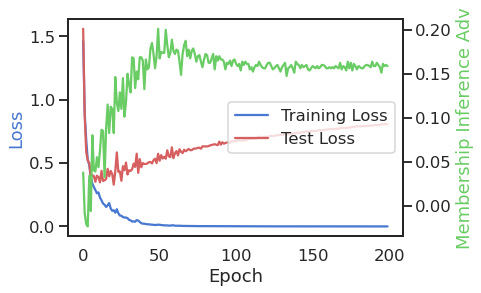

In [128]:
plt.figure()

ax1 = plt.gca()
ax1.plot(info['train_l'], color='b', label='Training Loss')
ax1.plot(info['test_l'], color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(info['adv'], color='g')
ax2.set_ylabel('Membership Inference Adv', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

# Differentially Private Training

In [132]:
info, model = run_experiment(1.0, 200, add_noise=True, throw_out_threshold=False)#.04)

Epoch 0: train loss 1.7776788473129272, test loss 1.8478350639343262, adv 0.06624999999999998, acc 0.485
Epoch 10: train loss 0.910993218421936, test loss 0.9333284497261047, adv 0.02750000000000008, acc 0.79
Epoch 20: train loss 0.7535842657089233, test loss 0.7453724145889282, adv 0.010000000000000009, acc 0.81
Epoch 30: train loss 0.5374277234077454, test loss 0.514203667640686, adv 0.007500000000000062, acc 0.84
Epoch 40: train loss 0.5658745765686035, test loss 0.5324504375457764, adv -0.011249999999999982, acc 0.825
Epoch 50: train loss 0.5554670691490173, test loss 0.5174294114112854, adv -0.012500000000000067, acc 0.835
Epoch 60: train loss 0.5775889754295349, test loss 0.5859603881835938, adv 0.05874999999999997, acc 0.845
Epoch 70: train loss 0.4656969904899597, test loss 0.4613317549228668, adv 0.006249999999999978, acc 0.845
Epoch 80: train loss 0.4546870291233063, test loss 0.4422059655189514, adv -0.0012499999999999734, acc 0.855
Epoch 90: train loss 0.4587225019931793, t

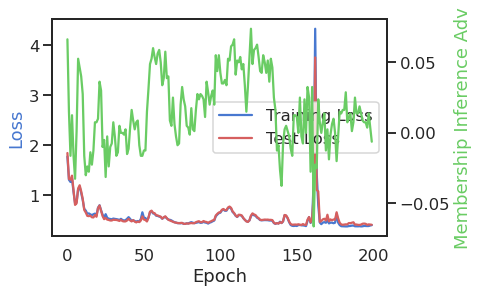

In [133]:
plt.figure()

ax1 = plt.gca()
ax1.plot(info['train_l'], color='b', label='Training Loss')
ax1.plot(info['test_l'], color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(info['adv'], color='g')
ax2.set_ylabel('Membership Inference Adv', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

## Threshold Training

In [136]:
info, model = run_experiment(1.0, 200, add_noise=False, throw_out_threshold=.03)

Epoch 0: train loss 1.3879280090332031, test loss 1.452136516571045, adv -0.0025000000000000577, acc 0.585
Epoch 10: train loss 1.2049956321716309, test loss 1.5101245641708374, adv 0.08625000000000005, acc 0.675
Epoch 20: train loss 1.3575310707092285, test loss 1.9285374879837036, adv 0.07250000000000001, acc 0.695
Epoch 30: train loss 1.3192318677902222, test loss 1.4283692836761475, adv 0.030000000000000027, acc 0.69
Epoch 40: train loss 1.3465803861618042, test loss 1.4695756435394287, adv 0.016249999999999987, acc 0.74
Epoch 50: train loss 1.152692437171936, test loss 1.2775360345840454, adv 0.06874999999999998, acc 0.72
Epoch 60: train loss 0.8851270079612732, test loss 1.3313992023468018, adv 0.09125000000000005, acc 0.735
Epoch 70: train loss 2.048891544342041, test loss 1.9790228605270386, adv 0.03499999999999992, acc 0.75
Epoch 80: train loss 1.2179555892944336, test loss 1.1863292455673218, adv 0.04249999999999998, acc 0.835
Epoch 90: train loss 1.2079187631607056, test los

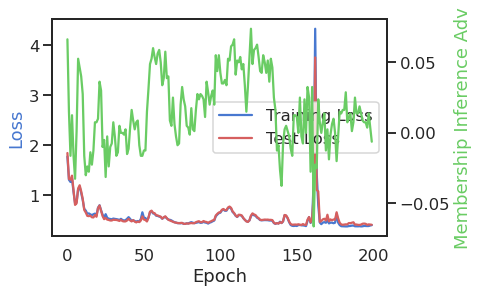

In [133]:
plt.figure()

ax1 = plt.gca()
ax1.plot(info['train_l'], color='b', label='Training Loss')
ax1.plot(info['test_l'], color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(info['adv'], color='g')
ax2.set_ylabel('Membership Inference Adv', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

# Both

In [138]:
info, model = run_experiment(1.0, 200, add_noise=True, throw_out_threshold=1.0)

Epoch 0: train loss 2.082746982574463, test loss 2.139181613922119, adv 0.07374999999999998, acc 0.37
Epoch 10: train loss 0.8763746023178101, test loss 0.849170982837677, adv 0.012499999999999956, acc 0.775
Epoch 20: train loss 0.8206017017364502, test loss 0.8167476654052734, adv 0.030000000000000027, acc 0.82
Epoch 30: train loss 0.8181373476982117, test loss 0.8106784820556641, adv 0.030000000000000027, acc 0.835
Epoch 40: train loss 0.8288778066635132, test loss 0.8142209649085999, adv 0.025000000000000022, acc 0.865
Epoch 50: train loss 0.6222548484802246, test loss 0.5709266066551208, adv -0.012500000000000067, acc 0.84
Epoch 60: train loss 0.696926474571228, test loss 0.6706299781799316, adv 0.008749999999999925, acc 0.86
Epoch 70: train loss 0.708230197429657, test loss 0.6800231337547302, adv -0.015000000000000013, acc 0.845
Epoch 80: train loss 0.5695737600326538, test loss 0.542917013168335, adv -0.03374999999999995, acc 0.86
Epoch 90: train loss 0.5581154227256775, test lo

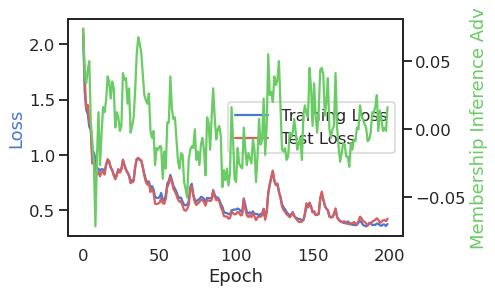

In [139]:
plt.figure()

ax1 = plt.gca()
ax1.plot(info['train_l'], color='b', label='Training Loss')
ax1.plot(info['test_l'], color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(info['adv'], color='g')
ax2.set_ylabel('Membership Inference Adv', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 

# Full Experiment Code

In [30]:
def run_one_experiment(epsilon, epochs, add_noise, throw_out_threshold):
    info, model = run_experiment(epsilon, epochs, 
                                 add_noise=add_noise, 
                                 throw_out_threshold=throw_out_threshold,
                                 logging=False)
    acc = accuracy(model, X_test, y_test)
    
    avg_train_l = nn.NLLLoss()(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                               torch.from_numpy(y_train).long())
    tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
    fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
    adv = tpr - fpr
    
    return acc, adv

In [31]:
run_one_experiment(1.0, 50, False, False)

(0.475, 0.43250000000000005)

In [32]:
non_private_results = [run_one_experiment(1.0, 50, False, False) for _ in range(5)]

In [36]:
accs, advs = list(zip(*non_private_results))
print(f'Accuracy: {np.mean(accs)} +- {np.std(accs)}')
print(f'Advantage: {np.mean(advs)} +- {np.std(advs)}')

Accuracy: 0.503 +- 0.015033296378372923
Advantage: 0.409 +- 0.014607361157991551


In [42]:
def plot_noise_results(epsilons, acc, acc_std, adv, adv_std):
    plt.figure()

    ax1 = plt.gca()
    markers, caps, bars = ax1.errorbar(epsilons, 
                                       acc, 
                                       acc_std, 
                                       color='b', 
                                       alpha=.8)
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax1.set_ylabel('Accuracy', color='b')
    ax1.tick_params('x', colors='b')

    ax2 = ax1.twinx()
    markers, caps, bars = ax2.errorbar(epsilons, 
                                       adv, 
                                       adv_std, 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax2.set_ylabel('Membership Inference Adv', color='r')
    ax2.tick_params('x', colors='r')

    ax1.set_xlabel('Epsilon (delta = 1e-5)')
    #fig.tight_layout()
    
    plt.xscale('log')
    plt.show() 

In [37]:
epsilons = [1, 10, 100, 1000]
num_runs = 5
num_epochs = 50

acc_mean = []
acc_std = []
adv_mean = []
adv_std = []

for epsilon in epsilons:
    print('Epsilon', epsilon)

    exp_results = [run_one_experiment(epsilon, num_epochs, True, False) for _ in range(num_runs)]
    accs, advs = list(zip(*exp_results))
    acc_mean.append(np.mean(accs))
    acc_std.append(np.std(accs))
    adv_mean.append(np.mean(advs))
    adv_std.append(np.std(advs))

Epsilon 1
Epsilon 10
Epsilon 100
Epsilon 1000


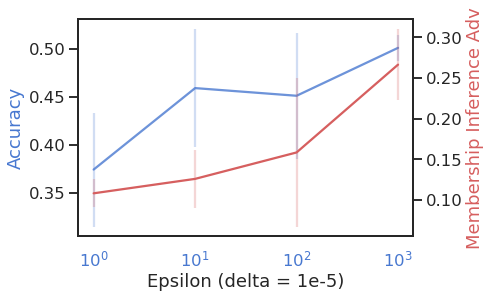

In [43]:
plot_noise_results(epsilons, acc_mean, acc_std, adv_mean, adv_std)